In [472]:
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.explain.config import ThresholdConfig
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
from bokeh.plotting import figure, show , ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import Category10_10
from bokeh.models import HoverTool
from sklearn.cluster import KMeans , AgglomerativeClustering , DBSCAN
from sklearn.metrics import silhouette_score



import sys
sys.path.append('/Users/sbhardwaj/Documents/GraphNodeClassification')
from src.models.models import GCN


In [473]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("mps device found!")
else:
    device = "cpu"
    print ("MPS device not found.")

mps device found!


In [474]:
data = torch.load(f"../data/processed/data_16_200_0.5.pt").to(device)
data

Data(x=[30732, 21], edge_index=[2, 142336], y=[30732, 200], dtype=torch.float32, g=Graph with 30732 nodes and 55802 edges, train_mask=[30732], val_mask=[30732], test_mask=[30732])

In [475]:
gcn_args = {
    'device': device,
    'num_layers': 4,
    'hidden_dim': 16,
    'dropout': 0.2,
    'lr': 0.005,
    'epochs': 1000,
}

model_path = model_path = "../models/gcn_16_200_0.5.pt"
loaded_model = GCN(data.x.shape[1] , gcn_args['hidden_dim'] , data.y.shape[1] , gcn_args['num_layers'] , gcn_args['dropout']).to(device)
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [514]:
threshhold_config = ThresholdConfig(threshold_type="topk" , value=20)

explainer = Explainer(
    model=loaded_model,
    algorithm=GNNExplainer(epochs=25),
    explanation_type='model',
    node_mask_type='object',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='probs',  # Model returns probabilities.
    ),
    threshold_config=threshhold_config
)

# Generate explanation for the node at index `10`:
index = 0
explanation = explainer(data.x, data.edge_index, index=index)
print(explanation.edge_mask)
print(explanation.node_mask)

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='mps:0')
tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='mps:0')


In [515]:
nodes = np.where(explanation.cpu().node_mask>0)
output = loaded_model(data.x , data.edge_index)

am = torch.argmax(output , dim=1)
un = np.unique(am.cpu().numpy() , return_counts=True)
un

(array([  0,   1,   4,  14,  15,  21,  22,  23,  24,  26,  30,  31,  35,
         41,  52,  59,  68,  69,  77,  85, 104, 165, 173, 178, 199]),
 array([    3,   389,     2,     3,  2675,     1,    73,  1313,  5246,
            1,   102,     1, 17543,    82,    18,    54,  1242,    23,
          478,   203,     5,    48,    72,  1154,     1]))

In [516]:
labels = {node:f"{node}\n{am[node]}" for node in nodes[0]}
labels[index] = f"{index}\n{am[index]}"

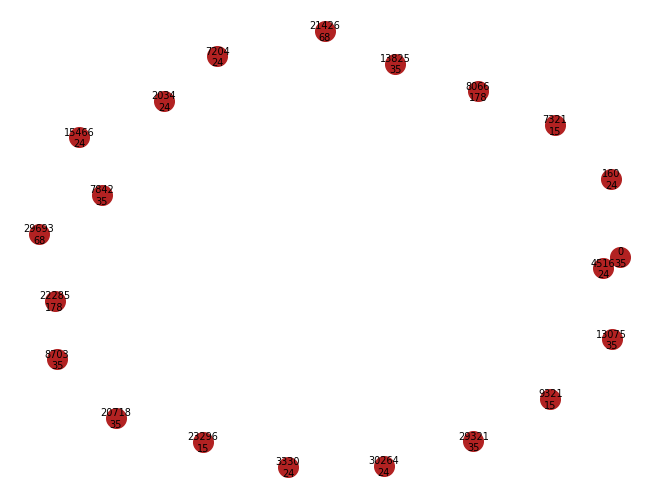

In [517]:
nx.draw(data.g.subgraph(nodes=np.append(nodes[0] , index)) , labels = labels , node_color="#B22222", node_size=200 , font_size=7 , with_labels=True)

## Node mask embedding 

In [503]:
output = loaded_model(data.x , data.edge_index)
am = torch.argmax(output , dim=1)
un = np.unique(am.cpu().numpy() , return_counts=True)
un

(array([  0,   1,   4,  14,  15,  21,  22,  23,  24,  26,  30,  31,  35,
         41,  52,  59,  68,  69,  77,  85, 104, 165, 173, 178, 199]),
 array([    3,   389,     2,     3,  2675,     1,    73,  1313,  5246,
            1,   102,     1, 17543,    82,    18,    54,  1242,    23,
          478,   203,     5,    48,    72,  1154,     1]))

In [504]:
un[1][5]

1

In [505]:
# which ones to plot? 4,8,13,59
grouped_xai = []

for i in range(un[0].shape[0]):
    if(un[1][i] > 5 and un[1][i] < 150):
        grouped_xai.append(un[0][i])

grouped_xai
    

[22, 30, 41, 52, 59, 69, 165, 173]

In [507]:
vectors = []
labels = []
node_list = []

for i , comm in enumerate(grouped_xai):

    sampled_nodes = np.where(am.cpu()==comm)[0]

    for node in (sampled_nodes):
        
        explanation = explainer(data.x, data.edge_index, index=node)
        vectors.append(explanation.node_mask.cpu().numpy())
        labels.append(comm)
        node_list.append(node)

    

    np.save("../data/interim/vectors_2.npy" , np.array(vectors).reshape((np.array(vectors).shape[0] , -1)))
    np.save("../data/interim/labels_2.npy" , np.array(labels).reshape((np.array(labels).shape[0] , -1)))
    np.save("../data/interim/node_list_2.npy" , np.array(node_list).reshape((np.array(node_list).shape[0] , -1)))

In [537]:
node_list = np.load("../data/interim/node_list_1.npy")
vectors = np.load("../data/interim/vectors_1.npy")
labels = np.load("../data/interim/labels_1.npy")

# mask = (labels==72)+(labels==104)+(labels==199)

# node_list = node_list[~mask]
# vectors = vectors[~mask[:,0]]
# labels = labels[~mask]

In [509]:
cmap = plt.colormaps["tab20"]

In [512]:
sc = StandardScaler()
scaled_vs = sc.fit_transform(vectors)

reducer = umap.UMAP(n_neighbors=500 , spread=10 , n_epochs=500 , min_dist=5)
embedding = reducer.fit_transform(scaled_vs , labels)

/Users/sbhardwaj/Documents/GraphNodeClassification/p2_env/lib/python3.10/site-packages/umap/umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/sbhardwaj/Documents/GraphNodeClassification/p2_env/lib/python3.10/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [539]:
# Create a new plot
source = ColumnDataSource(data=dict(x=embedding[:,0], y=embedding[:,1], labels=[str(i) for i in labels] , node_list=node_list))
p = figure(title="Simple Scatter Plot", x_axis_label='x', y_axis_label='y')

colors = factor_cmap('labels', palette=Category10_10, factors=sorted(set([str(i) for i in labels])))

# Add a circle renderer with a size, color, and alpha
p.circle("x" , "y" , size=5, color=colors, legend_field='labels', source=source)

hover = HoverTool(tooltips=[("Node:", "@node_list")])
p.add_tools(hover)
# Show the plot
show(p)

Silhouette Score: 0.5056025


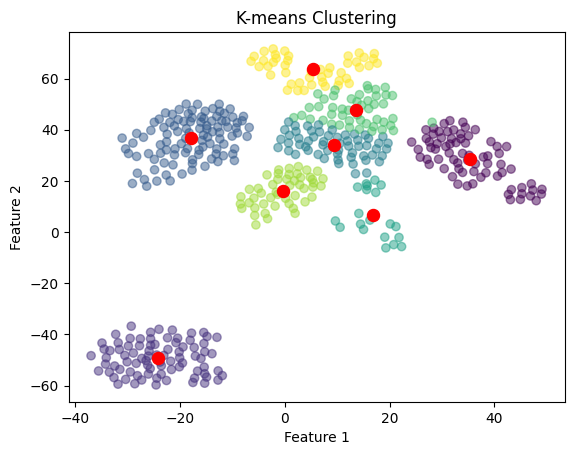

In [545]:
kmeans = KMeans(n_clusters=np.unique(labels).shape[0])
cluster_labels = kmeans.fit_predict(embedding)

silhouette_avg = silhouette_score(embedding, cluster_labels)
print("Silhouette Score:", silhouette_avg)

plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='.', s=300, c='red')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Silhouette Score: 0.4995074


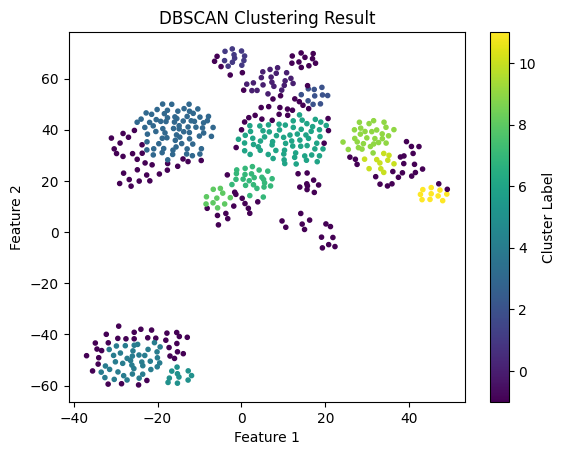

In [543]:
db_scan = DBSCAN(eps=4 , min_samples=10)
db_cluster_labels = db_scan.fit_predict(embedding)

mask = (db_cluster_labels != -1)
silhouette_avg = silhouette_score(embedding[mask], db_cluster_labels[mask])
print("Silhouette Score:", silhouette_avg)

plt.scatter(embedding[:, 0], embedding[:, 1], c=db_cluster_labels, cmap='viridis', marker='.')
plt.title("DBSCAN Clustering Result")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Cluster Label")
plt.show()

Silhouette Score: 0.4995074


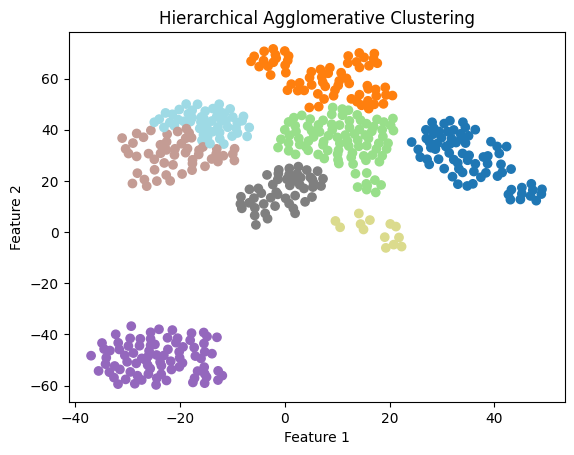

In [549]:
agglomerative = AgglomerativeClustering(n_clusters=np.unique(labels).shape[0])

# Fit AgglomerativeClustering object to the data and predict cluster labels
labels = agglomerative.fit_predict(embedding)
silhouette_avg = silhouette_score(embedding[mask], db_cluster_labels[mask])
print("Silhouette Score:", silhouette_avg)

# Plot the clusters
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap)
plt.title('Hierarchical Agglomerative Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()